## 1. Preprocessing: Loading, Augmenting, and Preparing the Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
# =============================
# PREPROCESSING SECTION
# =============================

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Define dataset paths
base_path = "/content/drive/My Drive/Updated_Lemon Data Set"
raw_lemons_path = os.path.join(base_path, "LRaw")
ripe_lemons_path = os.path.join(base_path, "LRipe")

# Function to load and preprocess images
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize for VGG-16
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load raw and ripe lemon images
raw_images, raw_labels = load_images(raw_lemons_path, 0)
ripe_images, ripe_labels = load_images(ripe_lemons_path, 1)

# Combine datasets
X = np.concatenate((raw_images, ripe_images), axis=0)
y = np.concatenate((raw_labels, ripe_labels), axis=0)

# Normalize image data to [0, 1]
X = X / 255.0  # Normalize pixel values

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=2)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation using ImageDataGenerator
augmenter = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill pixels for augmented images
)

# Augment the training data
ripe_augmented = augmenter.flow(X_train[y_train[:, 1] == 1], y_train[y_train[:, 1] == 1], batch_size=32)

train_generator = augmenter.flow(X_train, y_train, batch_size=32)


In [15]:
# =============================
# PREPROCESSING SECTION **************************Udated
# =============================

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
base_path = "/content/drive/My Drive/Updated_Lemon Data Set"
raw_lemons_path = os.path.join(base_path, "LRaw")
ripe_lemons_path = os.path.join(base_path, "LRipe")

# Function to load and preprocess images
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize for VGG-16
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load raw and ripe lemon images
raw_images, raw_labels = load_images(raw_lemons_path, 0)
ripe_images, ripe_labels = load_images(ripe_lemons_path, 1)

# Combine datasets
X = np.concatenate((raw_images, ripe_images), axis=0)
y = np.concatenate((raw_labels, ripe_labels), axis=0)

# Normalize image data to [0, 1]
X = X / 255.0  # Normalize pixel values

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=2)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation using ImageDataGenerator
augmenter = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill pixels for augmented images
)

# Augment the entire training dataset
train_generator = augmenter.flow(X_train, y_train, batch_size=32)

# Targeted augmentation for the "Ripe" class
ripe_augmented = augmenter.flow(
    X_train[np.argmax(y_train, axis=1) == 1],  # Select only "Ripe" class images
    y_train[np.argmax(y_train, axis=1) == 1],
    batch_size=32
)


## 2. Model Setup: VGG16 with Custom Layers


In [16]:
# =============================
# MODEL SETUP SECTION
# =============================

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 pre-trained model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers ****************# Unfreeze additional layers UPDATE
for layer in vgg_base.layers[-8:]:    # Adjust based on computational capacity
    #layer.trainable = False  # Retain pre-trained weights
    layer.trainable = True
# Add custom layers for binary classification
# vgg_base,
 #   Flatten(),  # Flatten the output from convolutional layers
  #  Dense(512, activation='relu'),  # Fully connected layer
   # Dropout(0.5),  # Dropout for regularization
    #Dense(256, activation='relu'),
    #Dropout(0.5),
    #Dense(2, activation='softmax')  # Output layer for binary classification
#])
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Reduce dropout to retain more features
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## 3. Training the Model

In [17]:
# =============================
# TRAINING SECTION
# =============================

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compute class weights to handle imbalance
#class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
#class_weights = dict(enumerate(class_weights))
class_weights = {0: 1.0, 1: 2.0}  # Higher weight for "Ripe" class

# Learning rate scheduler to dynamically adjust the learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

# Train the model
history = model.fit(
    train_generator,  # Use augmented data generator
    validation_data=(X_test, y_test),
    epochs=20,
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[lr_scheduler],  # Use learning rate scheduler
    verbose=1
)


KeyboardInterrupt: 

## 4. Evaluation and Visualization

5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 17s/step - accuracy: 0.8695 - loss: 0.3031
Test Loss: 0.3099
Test Accuracy: 87.14%


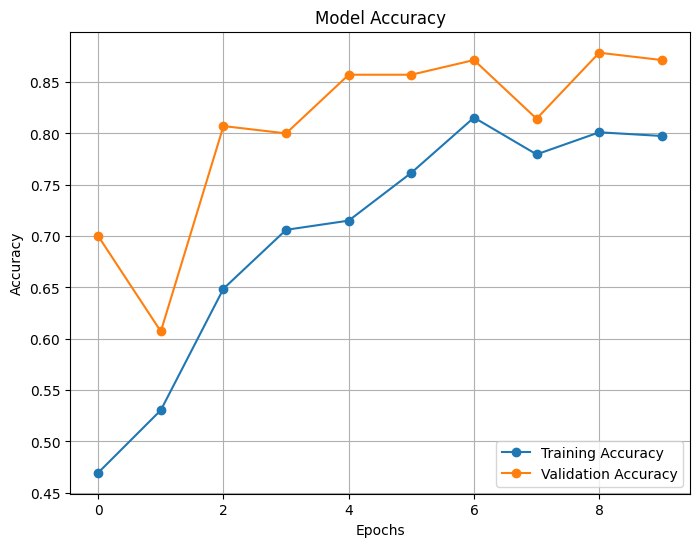

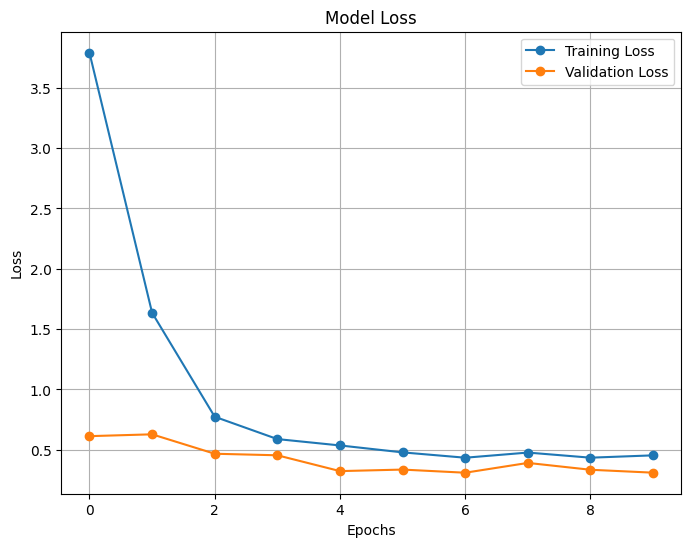

5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 18s/step


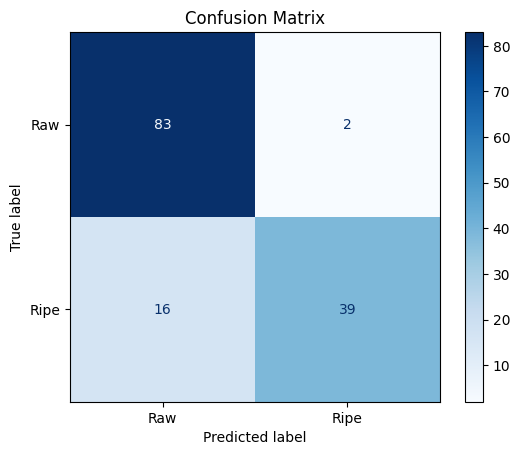

Classification Report:
               precision    recall  f1-score   support

         Raw       0.84      0.98      0.90        85
        Ripe       0.95      0.71      0.81        55

    accuracy                           0.87       140
   macro avg       0.89      0.84      0.86       140
weighted avg       0.88      0.87      0.87       140



In [13]:
# =============================
# EVALUATION SECTION
# =============================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Raw', 'Ripe'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Raw', 'Ripe']))


In [14]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 18s/step
ROC-AUC Score: 0.9561


## Step 5: Save the Trained Model
### Save the trained model for deployment.

In [ ]:
model.save('vgg16_lemon_classifier.h5')


## Load the Model and Make Predictions:

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Load the saved VGG-16 model
loaded_model = load_model('/content/vgg16_lemon_classifier.h5')

def predict_image(img_path):
    """
    Preprocess the input image and predict its class.
    Args:
        img_path (str): Path to the image.
    Returns:
        str: Predicted class ("Ripe" or "Raw").
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize for VGG-16
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values to [0, 1]

    # Predict using the loaded model
    prediction = loaded_model.predict(img_array)
    return "Ripe" if prediction[0][0] > 0.5 else "Raw"

# Define the image path (TEST INPUT IMAGE)
img_path = '/content/Lemon3.jpg'

# Check if the file exists and make predictions
if os.path.exists(img_path):
    # Load and display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

    # Predict the class
    result = predict_image(img_path)

    # Display the prediction on the image
    plt.text(10, 10, f'The predicted class is: {result}', color='red', fontsize=20, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

    print(f'The predicted class is: {result}')
else:
    print(f"File not found: {img_path}")